In [1]:
%matplotlib inline

In [189]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn
import torch.optim
from torch.autograd import Variable
import torch.nn.functional as F
#import matplotlib.pyplot as plt

In [209]:
#Load data
data_dir = Path('ALL_CDs')
files = list(data_dir.iterdir())
#print (files)

In [210]:
def read_dat(filename):
    with open(filename, 'r') as f:
        data = [x.strip() for x in f.readlines()]
        data = [x.split() for x in data if x != '']
        data = [(float(x[0]), float(x[1])) for x in data]
        
    return data

In [211]:
data = [np.array(read_dat(file)) for file in files]

In [212]:
#Reshape
crutch = 25
precision=1
scale = 1
data = {
    f'{file.stem}': pd.Series(data=x[:,1], index=np.array(x[:,0] * precision, dtype=np.uint32))  * scale
    for file, x in zip(files, data)
}

In [213]:
data = pd.DataFrame(data)

In [214]:
data.head()

,frame390-remd,frame304-remd,frame154-remd,frame332-remd,frame381-remd,frame1034-traj2,frame149-remd,frame33-remd,frame1280-traj2,frame1304-traj3,...,frame103-remd,frame74-remd,frame234-remd,frame720-traj1,frame1204-traj1,frame676-remd,frame1268-traj1,frame766-traj3,frame237-remd,frame144-remd
200,-168.874854,500.772728,439.895046,160.816567,168.649988,-749.946048,-66.039431,-59.475094,-492.622363,563.735874,...,704.032710,402.051577,179.025160,-393.029641,-497.523822,26.789386,-443.586007,1346.159995,-475.566642,527.160352
201,-181.758444,482.431186,381.928806,120.588647,145.294969,-871.972128,-52.008710,-89.349227,-509.955285,570.103427,...,676.093057,377.696953,175.689152,-364.695232,-477.960305,10.895138,-395.256491,1349.269909,-489.686090,447.290875
202,-188.782317,456.563741,325.068105,84.813408,125.538241,-977.271367,-37.220515,-114.396284,-524.724232,567.048007,...,642.194355,349.117113,170.617343,-338.390408,-454.188504,-4.247580,-349.665239,1335.727151,-496.709100,370.396258
203,-190.448309,424.838243,271.027788,53.927520,109.216127,-1064.016870,-22.398024,-134.407925,-534.883708,555.096766,...,603.485885,317.743952,164.116414,-313.826282,-426.901832,-17.883477,-307.213942,1305.594124,-496.353930,298.505861
204,-187.412249,388.936503,221.114959,28.093046,95.976070,-1130.939989,-8.201474,-149.313756,-538.894565,535.119851,...,561.120553,284.903641,156.439808,-290.648774,-396.848008,-29.481995,-268.133328,1259.719992,-488.682177,233.137076


In [215]:
#np.savetxt(r'/home/farkhad/BoNTA/1XTGA_SASA/Rdistrs/nans.dat', data,  fmt='%d')
# print(data.tail)
print (data.shape)

(131, 977)


In [216]:
data_nona = data.dropna()
print (data.shape, '->', data_nona.shape)

(131, 977) -> (131, 977)


In [217]:
data_nona.head()

,frame390-remd,frame304-remd,frame154-remd,frame332-remd,frame381-remd,frame1034-traj2,frame149-remd,frame33-remd,frame1280-traj2,frame1304-traj3,...,frame103-remd,frame74-remd,frame234-remd,frame720-traj1,frame1204-traj1,frame676-remd,frame1268-traj1,frame766-traj3,frame237-remd,frame144-remd
200,-168.874854,500.772728,439.895046,160.816567,168.649988,-749.946048,-66.039431,-59.475094,-492.622363,563.735874,...,704.032710,402.051577,179.025160,-393.029641,-497.523822,26.789386,-443.586007,1346.159995,-475.566642,527.160352
201,-181.758444,482.431186,381.928806,120.588647,145.294969,-871.972128,-52.008710,-89.349227,-509.955285,570.103427,...,676.093057,377.696953,175.689152,-364.695232,-477.960305,10.895138,-395.256491,1349.269909,-489.686090,447.290875
202,-188.782317,456.563741,325.068105,84.813408,125.538241,-977.271367,-37.220515,-114.396284,-524.724232,567.048007,...,642.194355,349.117113,170.617343,-338.390408,-454.188504,-4.247580,-349.665239,1335.727151,-496.709100,370.396258
203,-190.448309,424.838243,271.027788,53.927520,109.216127,-1064.016870,-22.398024,-134.407925,-534.883708,555.096766,...,603.485885,317.743952,164.116414,-313.826282,-426.901832,-17.883477,-307.213942,1305.594124,-496.353930,298.505861
204,-187.412249,388.936503,221.114959,28.093046,95.976070,-1130.939989,-8.201474,-149.313756,-538.894565,535.119851,...,561.120553,284.903641,156.439808,-290.648774,-396.848008,-29.481995,-268.133328,1259.719992,-488.682177,233.137076


In [218]:
#nans=open("nans.dat",'w')
#for line in data:
#    nans.write(str(line)+'\n')
#nans.close()

In [219]:
coords_weights = np.ones((len(data_nona)), dtype=np.float32)
#coords_weights[data.index > 30] = 1
#coords_weights[data_nona.index > 250] = 2500000
#coords_weights[data_nona.index > 720] = 200000
#coords_weights[data_nona.index > 800] = 70000

In [220]:
coords_weights[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [221]:
#Normalize data
y_column = '4053W'
X_columns = [c for c in data_nona.columns if c != y_column]
#print (y_column)
#print (X_columns)

y = data_nona[y_column].values.astype(np.float32)
X = data_nona[X_columns].values.astype(np.float32)

print(f'X: {X.shape}, y: {y.shape}')

X: (131, 976), y: (131,)


In [222]:
#Build a neural network

X = Variable(torch.from_numpy(X))
y = Variable(torch.from_numpy(y))
coords_weights = Variable(torch.from_numpy(coords_weights))

In [223]:
print(X.size(), y.size())

torch.Size([131, 976]) torch.Size([131])


In [224]:
w = torch.nn.Parameter(torch.randn(X.size(1)))
#print(w.size())
#print(w)
optimizer = torch.optim.Adam([w], lr=0.01)

In [225]:
nb_iterations = 20000
for i in range(nb_iterations):
    optimizer.zero_grad()
    
    w_prob = F.softmax(w)
    approx = torch.sum(X *crutch* w_prob, dim=-1) - y

    loss = torch.mean(torch.pow(coords_weights * approx, 2))
    pure_mse = torch.mean(torch.pow(approx, 2))
    
    loss.backward()
    optimizer.step()
    #print(pure_mse.data)
    #if (i + 1) % 500 == 0: 
     #   print(f'Iteration: {i+1}, loss: {loss.data[0]}, mean squared error: {pure_mse.data[0]}')
print(pure_mse)
    

/home/klyuchnikov/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


tensor(222458.6875, grad_fn=<MeanBackward0>)


In [226]:
w_optimal = F.softmax(w).data.numpy()
y_approx = data[X_columns]*crutch * w_optimal
data['y_approx'] = y_approx.sum(axis=1)
#print(data['y_approx'])
#appr=open('approx_data.dat','w')
#appr.write(data['y_approx'])
data['y_approx'].to_csv('fit.dat', sep='\t', index=True)
#np.savetxt(r'/home/farkhad/BoNTA/1XTGA_SASA/Rdistrs/approx.dat', data['y_approx'],  fmt='%d')
w_list = []
for name, w_o in zip(X_columns, w_optimal):
    #print(f'{name}: {w_o}')
    #print(name, w_o)
    w_list.append(str(name) + '\t' +str(w_o))

#appr.close
w_file = open('weights.dat','w')
for i in range (len(w_list)):
    w_file.write(str(w_list[i])+'\n')

w_file.close()
sorted(w_list, key = lambda x: x[1])

/home/klyuchnikov/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


['frame390-remd\t8.642236e-09',
 'frame304-remd\t2.795366e-09',
 'frame154-remd\t5.916864e-09',
 'frame332-remd\t1.49431e-08',
 'frame381-remd\t5.0592125e-10',
 'frame1034-traj2\t2.7488434e-09',
 'frame149-remd\t4.606213e-09',
 'frame33-remd\t2.0296052e-09',
 'frame1280-traj2\t5.162592e-09',
 'frame1304-traj3\t3.6704795e-10',
 'frame416-traj2\t4.6136538e-08',
 'frame642-remd\t3.0953449e-09',
 'frame616-remd\t8.940731e-10',
 'frame569-remd\t6.1674776e-08',
 'frame140-traj2\t8.722403e-09',
 'frame46-remd\t4.2704884e-09',
 'frame171-remd\t1.890404e-09',
 'frame598-remd\t1.0152652e-08',
 'frame589-remd\t6.750465e-10',
 'frame1338-traj3\t2.5461369e-09',
 'frame612-remd\t1.3328411e-09',
 'frame84-remd\t1.5904915e-07',
 'frame134-remd\t1.3722946e-08',
 'frame614-remd\t3.2567822e-09',
 'frame346-remd\t1.2385942e-09',
 'frame206-remd\t1.7284141e-09',
 'frame538-remd\t2.2386206e-09',
 'frame104-remd\t1.6839348e-08',
 'frame76-remd\t0.07394548',
 'frame384-remd\t1.1846397e-09',
 'frame639-remd\t1

<AxesSubplot:>

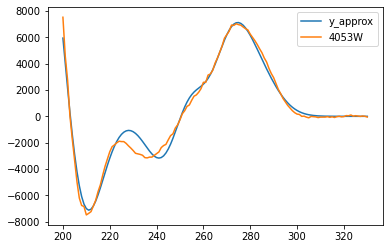

In [227]:
data[['y_approx',y_column]].plot()

In [46]:
data_dir

PosixPath('25mer2')